### ECE/CS/ISyE 524 &mdash; Introduction to Optimization &mdash; Fall 2024 ###

# Manufacturing Pipeline Optimization #

#### Arnav Deshpande (aadeshpande3@wisc.edu), Shuibai Zhang (szhang967@wisc.edu) and Ajeenckya Mahadik (avmahadik@wisc.edu)

*****

### Table of Contents

1. [Introduction](#1.-Introduction)
    1. [Pipeline Structure](#1.1.-Pipeline-Structure)
    2. [Initial Data](#1.2.-Initial-Data)
1. [Mathematical Model](#2.-Mathematical-model)
    1. [Assumptions](#2.1.-Assumptions)
    2. [Model](#2.2.-Model)
1. [Solution](#3.-Solution)
    1. [Sensitivity Analysis](#3.1.-Sensitivity-Analysis)
1. [Results and Discussion](#4.-Results-and-discussion)
    1. [Initial Observations](#4.1.-Initial-Observations)
1. [Conclusion](#5.-Conclusion)

## 1. Introduction ##

In a manufacturing environment, process complexity often leads to inefficiencies such as production delays, increased machine downtime etc. As processes become more complex, the time and resources needed for each unit of production also rise, negatively affecting overall throughput. By optimizing the scheduling and sequencing of these complex processes, the goal is to minimize production losses, enhance efficiency, and improve the cost-effectiveness of the production line. This optimization is particularly crucial in industries like automotive or electronics manufacturing, where high process variability can significantly impact productivity. 

The primary goal of this project was to design and implement a mathematical model that captures the intricacies of task allocation in a multi-station manufacturing system for an engine production pipeline. Our approach leverages optimization techniques to minimize total idle costs while adhering to practical constraints, such as station time limits and task capacities. The work focuses on balancing efficiency and feasibility to improve the overall performance of the manufacturing process.

## 1.1. Pipeline Structure ##
The pipeline looks like this: 
![pipeline_diagram]


- We are considering this pipeline for the manufacturing of automobile engines. The diagram shows us two parallel lanes of flow and 50 internal stations. Each station is labelled from 10 through 500. Stations 460 to 500 are care stations, meant for QA checks, inspections and defective piece removal. The rest of the stations are workstations for performing processing on the engine.   
- Every workstation consists of a machine and a human operator (worker).

- Each machine has a number of processes that it will perform on the engine.
The types of machines are:
  - Nut-runner
    - A nut-runner is a specialized tool or machine designed to tighten fasteners (bolts, screws, or nuts) to a specified torque level during assembly operations. 
  - Scanner
    - A scanner in manufacturing is a device used to verify the presence and orientation of components and assemblies through data reading or imaging.<br><br>     
  
- The types of processing that can be performed on the engines are:
  - Scanning
    - Scanning ensures that all components and subassemblies are present, and the correct ones are being fitted to the engine. A scanner machine (like a barcode or QR code reader) reads identification marks on parts to verify that the correct parts are being used.
  - Final Tightening
    - Final tightening ensures that critical fasteners, such as bolts and screws, are torqued to exact specifications for safety and reliability.  
  - Loose tightening
    - Loose tightening pre-positions fasteners during the early stages of assembly, ensuring they are ready for final tightening.
  - Pre-assembly
    - Pre-assembly involves partially assembling components or subassemblies before the main assembly process to increase efficiency. Workers or automated systems combine smaller parts into subassemblies. 
  - Fitment
    - Fitment ensures that components are properly aligned and securely attached during the main assembly process. <br><br>  
    
- The On-line Part Storage contains parts and materials that are required for the assembly process. 

- The term “fastener” refers to bolts, nails, screws, magnets and other kinds of connecting devices. The Fastener Storage Racks are responsible for storing them. Three fastener storage racks are present every 50 stations. 

- The Transmission Line is a specialized area where components are assembled.

- An operator is typically represented by symbol: ![Worker](https://i.imgur.com/H3K3903.png "Worker Image"). They are at the forefront of the line and perform all manual tasks.  

[pipeline_diagram]: https://i.imgur.com/guu9kGy.png

### 1.2. Initial Data ###

In [15]:
using CSV
using DataFrames

df = CSV.read("DCT_updated.csv", DataFrame)

Row,station_index_j,Station_Number_J,Task_Index_I,Name_of_task_index_i,Completion_Time_seconds,Delay_seconds,automatic_U,assembly_time
,Int64,String15,Int64,String,Int64,Int64,String1,Int64
1,1,10-A,1,ENGINE LOADING,30,0,0,0
2,2,10-B,2,BRACKET OVER INTAKE (TRANSFER FROM ENGINE),12,7,A,3
3,2,10-B,3,EVAP BRACKET ON CYLINDER HEAD COVER FRONT,13,0,A,3
4,2,10-B,4,EVAP BRACKET ON INTAKE,10,0,A,3
5,3,20,5,#ENGINE SET-UP AND SCANNING,35,7,A,0
6,4,30,6,CATCON SUPPORT BKT (RIGHT),33,6,A,3
7,4,30,7,CATCON SUPPORT BKT (LEFT),31,0,A,3
8,5,40,8,BUFFER,0,6,0,0
9,6,50-A,9,TRANSMISSION LOADING & SCANNING-0503,31,7,M,5


### Understanding the Data:

- The data above is gathered by our team member Ajeenckya from his previous work at the [Fiat Automobile Production Pipeline in Ranjangaon Pune, India](https://www.youtube.com/watch?v=QsgeP0H_6qQ)
- The plant is a joint venture between Fiat and Tata Motors. 
- The CSV file is a close approximation of the data they use to produce engines for the Nexon and the Safari vehicles. It is not the actual data, as that would be a violation of NDA!
- The data has a few columns to understand:
  - station_index_j: The primary key of sorts. It is assigned to every station in the pipeline. Some stations like Station 10 have multiple sub-divisions, and station_index_j stays = 1 for all of these stations.
  - Station_Number_J: The name of the station. It ranges from 10 - 480 in the above case.
  - Task_Index_I: The key associated with task I.
  - Name_of_task_index_i: The name associated with task I.
  - Completion_Time_seconds: The time required to complete the task, not considering any delay or assembly time.
  - Delay_seconds: The delay associated with every task.
  - automatic_U: A column that assigns the value M, A,or 0 based on whether the task is going to be Manual or Automatic, or none of the above.
  - assembly_time: The time required to assemble the parts associated with a particular task.


## 2. Mathematical model ##

### 2.1. **Assumptions** 
- Every station has a machine.
- Every operator has 100% effciency.
- There is no delay between supply of parts. All parts are available at all times.
- We are not considering any human errors.
- We are not considering any other miscellanous delays.
- The initial costs of C1, C2, C3 (electricity, compressed air, manpower) are based off of an approximation on-premise costs at the automobile plants.

### 2.2. **Model**
### Model type:
- The model is a Mixed Integer Linear Program as we have Binary Variables as well as linear constraints. There are no quadratic constraints.

## Sets
- **Tasks**: $T = \{1, 2, ..., n\}$ — Set of all tasks.
- **Stations**: $S = \{1, 2, ..., m\}$ — Set of all stations.
- **Precedency Constraints**: $P = \{(t_i, t_j)\}$ — Pairs of tasks where task $t_i$ must be completed before task $t_j$.

---

## Parameters
- **completion_time[i]**: Time required to complete task $i$ (in seconds).
- **assembly_time[i]**: Time required to assemble task $i$ (in seconds).
- **process_type[i]**: Process type of task $i$ ("A" for automatic, "M" for manual, "0" for fixed station).
- **original_station[i]**: Original station where task $i$ must be assigned if $process\_type[i] = 0$.
- **max_tasks_per_station**: Maximum number of tasks that can be assigned to a single station.
- **delay_time**: Delay time introduced if the first task of a station is automatic or manual:
  - 7 seconds for automatic ($process\_type[i] = 'A'$),
  - 6 seconds for manual ($process\_type[i] = 'M'$).
- **$C = [c_1, c_2, c_3]$**: Costs for electricity, compressed air, and manpower, respectively.
- **idle_cost_machines**: Idle cost per unit time for machines.
- **idle_cost_people**: Idle cost per unit time for people.
- **station_time_limit**: Maximum time available per station (e.g., 61 seconds).

---

## Decision Variables
1. **$x[i, j]$**: Binary variable:
   - $x[i, j] = 1$ if task $i$ is assigned to station $j$, otherwise $x[i, j] = 0$.

2. **$y[j]$**: Binary variable:
   - $y[j] = 1$ if station $j$ is active (i.e., at least one task is assigned), otherwise $y[j] = 0$.

3. **idle_time[j]**: Continuous variable:
   - Idle time for station $j$ (in seconds), $idle\_time[j] \geq 0$.

4. **$first_task[j, t]$**: Binary variable:
   - $first_task[j, t] = 1$ if task $t$ is the first task on station $j$, otherwise $first_task[j, t] = 0$.

---

## Objective Function

Minimize the total cost:

$$
\text{Minimize } Z = \sum_{i \in T, j \in S} (c_1 + c_2 + c_3) \cdot \text{completion\_time}[i] \cdot x[i, j]
+ \sum_{j \in S} (\text{idle\_cost\_machines} + \text{idle\_cost\_people}) \cdot \text{idle\_time}[j]
$$

This objective function minimizes:
1. The total operating cost (electricity, compressed air, manpower) associated with task completion.
2. The idle costs of machines and workers due to unused station time.

---

## Constraints

### 1. Task Assignment Constraint
Each task must be assigned to exactly one station:

$$
\sum_{j \in S} x[i, j] = 1, \quad \forall i \in T
$$

### 2. Station Activation Constraint
A station is active if at least one task is assigned:

$$
y[j] \geq x[i, j], \quad \forall i \in T, \forall j \in S
$$

### 3. Station Time Limit Constraint
The total processing time of tasks assigned to a station, including delays, must not exceed the station time limit:

$$
\sum_{i \in T} (completion\_time[i] + assembly\_time[i]) \cdot x[i, j] + \text{delay\_time}[j] \leq \text{station\_time\_limit}, \quad \forall j \in S
$$

### 4. Idle Time Constraint
Idle time for a station is the difference between the station time limit and the total time used by tasks (including delays):

$$
\text{idle\_time}[j] \geq \text{station\_time\_limit} - \sum_{i \in T} (completion\_time[i] + assembly\_time[i]) \cdot x[i, j] - \text{delay\_time}[j], \quad \forall j \in S
$$

### 5. First Task Constraint
Only one task can be the first task at an active station:

$$
\sum_{t \in T} \text{first\_task}[j, t] = y[j], \quad \forall j \in S
$$

If task $t$ is the first task at station $j$, it must also be assigned to that station:

$$
\text{first\_task}[j, t] \leq x[t, j], \quad \forall t \in T, \forall j \in S
$$

### 6. Precedency Constraints
Tasks must follow the defined precedency order:

$$
\sum_{j \in S} j \cdot x[t_i, j] \leq \sum_{j \in S} j \cdot x[t_j, j], \quad \forall (t_i, t_j) \in P
$$

### 7. Process Type Constraints
If a task has a fixed process type ($process\_type[i] = 0$), it must be assigned to its original station:

$$
x[i, \text{original\_station}[i]] = 1, \quad \forall i \in T \text{ where } process\_type[i] = 0
$$

It cannot be assigned to any other station:

$$
x[i, j] = 0, \quad \forall j \neq \text{original\_station}[i], \forall i \in T \text{ where } process\_type[i] = 0
$$

### 8. Station Task Capacity Constraint
The number of tasks assigned to a station cannot exceed the maximum allowed:

$$
\sum_{i \in T} x[i, j] \leq \text{max\_tasks\_per\_station}, \quad \forall j \in S
$$

---

## Explanation of the Model Components

1. **Decision Variables**:
   - $x[i, j]$ determines which station a task is assigned to.
   - $y[j]$ activates a station if it has any tasks assigned.
   - $idle\_time[j]$ calculates unused time at a station.
   - $first\_task[j, t]$ identifies the first task of a station.

2. **Parameters**:
   - Include task times, station limits, and costs for operations and idle time.  

3. **Objective Function**:
   - Balances task processing costs and idle costs to minimize total costs.  

4. **Constraints**:
   - Ensure valid task assignments, satisfy station time and capacity limits, enforce precedency relationships, and handle process-specific task assignments.  

## 3. Solution ##

In [1]:
using DataFrames
using CSV

In [2]:
df = CSV.read("DCT_updated.csv", DataFrame)

Row,station_index_j,Station_Number_J,Task_Index_I,Name_of_task_index_i,Completion_Time_seconds,Delay_seconds,automatic_U,assembly_time
,Int64,String15,Int64,String,Int64,Int64,String1,Int64
1,1,10-A,1,ENGINE LOADING,30,0,0,0
2,2,10-B,2,BRACKET OVER INTAKE (TRANSFER FROM ENGINE),12,7,A,3
3,2,10-B,3,EVAP BRACKET ON CYLINDER HEAD COVER FRONT,13,0,A,3
4,2,10-B,4,EVAP BRACKET ON INTAKE,10,0,A,3
5,3,20,5,#ENGINE SET-UP AND SCANNING,35,7,A,0
6,4,30,6,CATCON SUPPORT BKT (RIGHT),33,6,A,3
7,4,30,7,CATCON SUPPORT BKT (LEFT),31,0,A,3
8,5,40,8,BUFFER,0,6,0,0
9,6,50-A,9,TRANSMISSION LOADING & SCANNING-0503,31,7,M,5


Set parameter Username
Set parameter LicenseID to value 2596131
Academic license - for non-commercial use only - expires 2025-12-05
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (22631.2))

CPU model: AMD Ryzen 5 7535HS with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 9820 rows, 9350 columns and 50779 nonzeros
Model fingerprint: 0x2895349d
Variable types: 55 continuous, 9295 integer (9295 binary)
Coefficient statistics:
  Matrix range     [1e+00, 6e+01]
  Objective range  [7e+00, 5e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 6e+01]
Presolve removed 5326 rows and 3743 columns
Presolve time: 0.21s
Presolved: 4494 rows, 5607 columns, 40191 nonzeros
Variable types: 0 continuous, 5607 integer (5553 binary)

Root relaxation: objective 2.796640e+04, 3371 iterations, 0.15 seconds (0.19 work units)

    Nodes    |    Current Node    |     Objec

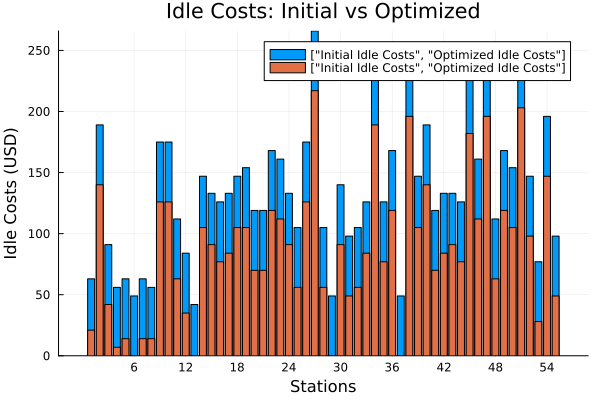

In [17]:
using CSV
using DataFrames
using JuMP
using Gurobi
using Plots
 
# Load data
file_path = "DCT_updated.csv"
data = CSV.read(file_path, DataFrame)
 
# Extract input data
stations = unique(data.station_index_j)
tasks = collect(1:size(data, 1))
completion_time = data.Completion_Time_seconds
assembly_time = data.assembly_time
process_type = data.automatic_U  # Assuming a column "process_type" exists for task types
process_name = data.Name_of_task_index_i
original_station = data.station_index_j
precedency = Dict(14 => [15], 15 => [16], 16 => [17], 19 => [20, 22], 20 => [21], 21 => [22], 23 => [24], 6 => [7], 7 => [14], #precedency helps us to 
                  27 => [28], 25 => [33], 33 => [34], 17 => [37], 34 => [35], 35 => [38], 26 => [39, 42], 39 => [40], #order the tasks in a 
                  21 => [41], 42 => [44], 43 => [46], 52 => [55], 41 => [49], 44 => [45], 50 => [51], 53 => [54], #specific manner that is
                  51 => [61], 61 => [62], 63 => [64], 79 => [80, 81, 82], 13=>[19, 33, 39, 43, 42, 23, 52], 37=>[63, 74, 56]) # required for assembly.
 
max_tasks_per_station = 4  # Max tasks allowed per station
 
# Parameters
C = [0.3, 0.1, 10.0]  # Costs: electricity, compressed air, manpower
idle_cost_machines = 2.0  # Idle cost per unit time for machines
idle_cost_people = 5.0  # Idle cost per unit time for people
 
# Model definition
model = Model(Gurobi.Optimizer)
 
# Decision variables
@variable(model, x[tasks, stations], Bin)  # Task assignment to stations
@variable(model, y[stations], Bin)  # Station activity
@variable(model, idle_time[j in stations] >= 0)  # Idle time per station
@variable(model, first_task[j in stations, t in tasks], Bin)  # 1 if task t is the first task on station j
 
# Create a dictionary to store initial idle time as expressions
initial_idle_time_expr = Dict(j => @expression(model, 63 - sum((completion_time[i] + assembly_time[i]) * x[i, j] for i in tasks)) for j in stations)
 
# Constraints
for j in stations
    # Skip stations where the first task is of process type 0
    @constraint(model, y[j] <= 1 - sum(first_task[j, t] for t in tasks if process_type[t] == "0"))
    # Ensure exactly one task is the first task if the station is active
    @constraint(model, sum(first_task[j, t] for t in tasks) == y[j])
    for t in tasks
        @constraint(model, first_task[j, t] <= x[t, j])
    end
    delay_time = sum((process_type[t] == "A" ? 7 : process_type[t] == "M" ? 6 : 0) * first_task[j, t] for t in tasks)
    station_time = sum((completion_time[i] + assembly_time[i]) * x[i, j] for i in tasks) + delay_time
    @constraint(model, station_time <= 63)
    # Idle time calculation
    @constraint(model, idle_time[j] >= 63 - station_time)
end
 
# Precedency constraints
for t in keys(precedency)
    for succ in precedency[t]
        @constraint(model, sum(x[t, j] * j for j in stations) <= sum(x[succ, j] * j for j in stations))
    end
end
 
# Process type constraints
for t in tasks
    if process_type[t] == "0"
        @constraint(model, x[t, original_station[t]] == 1)
        for j in stations
            if j != original_station[t]
                @constraint(model, x[t, j] == 0)
            end
        end
    end
end
 
# Each task is assigned to exactly one station
@constraint(model, [i in tasks], sum(x[i, j] for j in stations) == 1)
 
# Ensure a station is active if at least one task is assigned
@constraint(model, [i in tasks, j in stations], y[j] >= x[i, j])
@constraint(model, x[1, 1] == 1)
@constraint(model, x[5, 3] == 1)
@constraint(model, x[9, 6] == 1)
@constraint(model, x[10, 7] == 1)
@constraint(model, x[11, 8] == 1)
@constraint(model, x[12, 9] == 1)
@constraint(model, x[13, 10] == 1)
@constraint(model, x[25, 18] == 1)
@constraint(model, x[26, 18] == 1)
@constraint(model, x[27, 18] == 1)
@constraint(model, x[36, 23] == 1)
@constraint(model, x[55, 37] == 1)
@constraint(model, x[63, 41] == 1)
@constraint(model, x[74, 48] == 1)
# Objective function: Minimize total cost
@objective(model, Min,
    sum((C[1] + C[2] + C[3]) * completion_time[i] * x[i, j] for i in tasks, j in stations) +
    sum(idle_cost_machines * idle_time[j] + idle_cost_people * idle_time[j] for j in stations)
)
 
# Solve the model
optimize!(model)
 
# Check feasibility
if termination_status(model) == MOI.INFEASIBLE
    println("Model is infeasible. Check constraints or data.")
    return
end
 
results = DataFrame(Station_No=Int[], Process_No=Int[], Process_Name=String[])
 
if termination_status(model) == MOI.OPTIMAL
    println("Optimal solution found!")
    println("Task assignments:")
    for i in tasks, j in stations
        if value(x[i, j]) > 0.5
            println("Task $i assigned to Station $j")
        end
    end
    println("Total cost: ", objective_value(model))
else
    println("No optimal solution found within the time limit.")
end
 
# Calculate initial and optimized idle times
initial_idle_time = Dict(j => value(initial_idle_time_expr[j]) for j in stations)
optimized_idle_time = Dict(j => value(idle_time[j]) for j in stations)
initial_idle_cost = [idle_cost_machines * initial_idle_time[j] + idle_cost_people * initial_idle_time[j] for j in stations]
optimized_idle_cost = [idle_cost_machines * optimized_idle_time[j] + idle_cost_people * optimized_idle_time[j] for j in stations]
 
# Calculate operating costs
initial_operating_cost = sum((C[1] + C[2] + C[3]) * completion_time[i] for i in tasks)
optimized_operating_cost = sum((C[1] + C[2] + C[3]) * completion_time[i] * value(sum(x[i, j] for j in stations)) for i in tasks)
 
# Calculate total costs
total_initial_cost = sum(initial_idle_cost) + initial_operating_cost
total_optimized_cost = sum(optimized_idle_cost) + optimized_operating_cost
 
# Calculate total savings
total_savings = total_initial_cost - total_optimized_cost
 
println("Total cost per cycle before optimization: \$", total_initial_cost)
println("Initial Idle Cost per cycle: \$", sum(initial_idle_cost))
println("Total cost per cycle after optimization: \$", total_optimized_cost)
println("Optimized Idle Cost per cycle: \$", sum(optimized_idle_cost))
println("Total savings from optimization: \$", total_savings)
 
# Prepare results for saving
if termination_status(model) == MOI.OPTIMAL
    println("Optimal solution found!")
    # Extract results
    results = DataFrame(
        station_index_j = [j for i in tasks for j in stations if value(x[i, j]) > 0.5],
        Task_Index_I = [i for i in tasks for j in stations if value(x[i, j]) > 0.5],
        Name_of_task_index_i = [process_name[i] for i in tasks for j in stations if value(x[i, j]) > 0.5]
    )
    # Sort results and save
    sorted_results = sort(results, :station_index_j)
    CSV.write("Optimized_DCT_Model.csv", sorted_results)
    println("Results saved to Optimized_DCT_Model.csv")
else
    println("Model did not find an optimal solution.")
end

station_labels = [string(j) for j in stations]
bar(
    station_labels,
    [initial_idle_cost optimized_idle_cost],
    xlabel="Stations",
    ylabel="Idle Costs (USD)",
    title="Idle Costs: Initial vs Optimized",
    label=["Initial Idle Costs", "Optimized Idle Costs"],
    legend=:topright
)

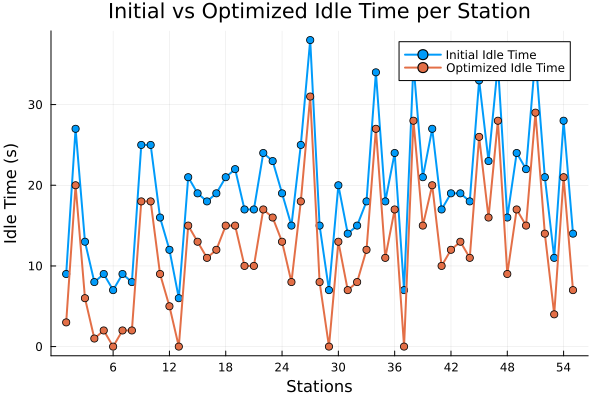

In [4]:
# Overlapping plot for initial vs optimized idle time
initial_idle_time_values = [initial_idle_time[j] for j in stations]
optimized_idle_time_values = [optimized_idle_time[j] for j in stations]
plot(
    station_labels,
    [initial_idle_time_values, optimized_idle_time_values],
    xlabel="Stations",
    ylabel="Idle Time (s)",
    title="Initial vs Optimized Idle Time per Station",
    label=["Initial Idle Time" "Optimized Idle Time"],
    linewidth=2,
    marker=:circle,
    legend=:topright
)

In [5]:
df2 = CSV.read("Optimized_DCT_Model.csv", DataFrame)

Row,station_index_j,Task_Index_I,Name_of_task_index_i
,Int64,Int64,String
1,1,1,ENGINE LOADING
2,1,50,"PIPE ASSY,INTERCOOLER TO INTAKE MANIFOLD"
3,2,6,CATCON SUPPORT BKT (RIGHT)
4,3,5,#ENGINE SET-UP AND SCANNING
5,3,72,SEPERATOR CLAMP(FOR OIL COOLER HOSES)
6,4,60,BRACKET OVER INTAKE (TRANSFER FROM ENGINE)
7,4,79,CLAMPS FOR ROUTING EVAP PIPE (ONLINE)
8,5,7,CATCON SUPPORT BKT (LEFT)
9,5,8,BUFFER


## 3.1. Sensitivity Analysis ##

### (Please make sure the above cells are ran before the one below!) ###

In [6]:
# Sensitivity Analysis
# Varying cost parameters
cost_scenarios = [
    (0.3, 0.1, 10.0),  # Base case
    (0.4, 0.2, 12.0),  # Increased costs
    (0.2, 0.05, 8.0),  # Decreased costs
]

time_scenarios = [63, 70, 50]  # Vary maximum station time
task_scenarios = [4, 5, 3]  # Vary max tasks per station

results_sensitivity = DataFrame(
    Scenario_Type=String[],
    Scenario_Value=Any[],
    Total_Cost=Float64[],
    Total_Savings=Float64[]
)

println("\n=== Sensitivity Analysis ===")

# Reuse station_time calculation as a global constraint for sensitivity analysis
station_time_constraints = Dict(j => @expression(
    model,
    sum((completion_time[i] + assembly_time[i]) * x[i, j] for i in tasks) +
    sum((process_type[t] == "A" ? 7 : process_type[t] == "M" ? 6 : 0) * first_task[j, t] for t in tasks)
) for j in stations)

# Function to update the station time constraints
function update_station_time_constraints(max_time)
    for j in stations
        @constraint(model, station_time_constraints[j] <= max_time)
    end
end

# Function to update the max task constraints
function update_max_task_constraints(max_tasks)
    for j in stations
        @constraint(model, sum(x[t, j] for t in tasks) <= max_tasks)
    end
end

# Analyzing cost parameter scenarios
for (i, (c1, c2, c3)) in enumerate(cost_scenarios)
    println("\n=== Scenario $(i): Cost Parameters C=($c1, $c2, $c3) ===")
    @objective(model, Min,
        sum((c1 + c2 + c3) * completion_time[i] * x[i, j] for i in tasks, j in stations) +
        sum(idle_cost_machines * idle_time[j] + idle_cost_people * idle_time[j] for j in stations)
    )
    optimize!(model)

    if termination_status(model) == MOI.OPTIMAL
        optimized_cost = objective_value(model)
        savings = total_initial_cost - optimized_cost
        println("  Total Cost: \$", optimized_cost)
        println("  Savings: \$", savings)
        push!(results_sensitivity, ("Cost", (c1, c2, c3), optimized_cost, savings))
    else
        println("  Optimization failed for this scenario.")
    end
    println("=============================================================================================================")
end

# Analyzing max station time scenarios
for (i, max_time) in enumerate(time_scenarios)
    println("\n=== Scenario $(i + length(cost_scenarios)): Max Station Time = $max_time ===")
    update_station_time_constraints(max_time)
    optimize!(model)

    if termination_status(model) == MOI.OPTIMAL
        optimized_cost = objective_value(model)
        savings = total_initial_cost - optimized_cost
        println("  Total Cost: \$", optimized_cost)
        println("  Savings: \$", savings)
        push!(results_sensitivity, ("Max Time", max_time, optimized_cost, savings))
    else
        println("  Optimization failed for this scenario.")
    end
    println("=============================================================================================================")
end

# Analyzing max tasks per station scenarios
for (i, max_tasks) in enumerate(task_scenarios)
    println("\n=== Scenario $(i + length(cost_scenarios) + length(time_scenarios)): Max Tasks Per Station = $max_tasks ===")
    update_max_task_constraints(max_tasks)
    optimize!(model)

    if termination_status(model) == MOI.OPTIMAL
        optimized_cost = objective_value(model)
        savings = total_initial_cost - optimized_cost
        println("  Total Cost: \$", optimized_cost)
        println("  Savings: \$", savings)
        push!(results_sensitivity, ("Max Tasks", max_tasks, optimized_cost, savings))
    else
        println("  Optimization failed for this scenario.")
    end
    println("=============================================================================================================")
end

# Save sensitivity analysis results
CSV.write("Sensitivity_Analysis_Results.csv", results_sensitivity)
println("Sensitivity analysis results saved to Sensitivity_Analysis_Results.csv")



=== Sensitivity Analysis ===

=== Scenario 1: Cost Parameters C=(0.3, 0.1, 10.0) ===
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (22631.2))

CPU model: AMD Ryzen 5 7535HS with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 9820 rows, 9350 columns and 50779 nonzeros
Model fingerprint: 0x2895349d
Variable types: 55 continuous, 9295 integer (9295 binary)
Coefficient statistics:
  Matrix range     [1e+00, 6e+01]
  Objective range  [7e+00, 5e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 6e+01]

MIP start from previous solve produced solution with objective 27966.4 (0.01s)
Loaded MIP start from previous solve with objective 27966.4

Presolve removed 5326 rows and 3743 columns
Presolve time: 0.22s
Presolved: 4494 rows, 5607 columns, 40191 nonzeros
Variable types: 0 continuous, 5607 integer (5553 binary)

Root relaxation: cutoff, 3371 iterations

In [7]:
df3 = CSV.read("Sensitivity_Analysis_Results.csv", DataFrame)

Row,Scenario_Type,Scenario_Value,Total_Cost,Total_Savings
,String15,String31,Float64,Float64
1,Cost,"(0.3, 0.1, 10.0)",27966.4,2625.0
2,Cost,"(0.4, 0.2, 12.0)",32863.6,-2272.2
3,Cost,"(0.2, 0.05, 8.0)",23180.5,7410.9
4,Max Time,63,23180.5,7410.9
5,Max Time,70,23180.5,7410.9


## 4. Results and discussion ##

### 4.1. Initial Observations ###

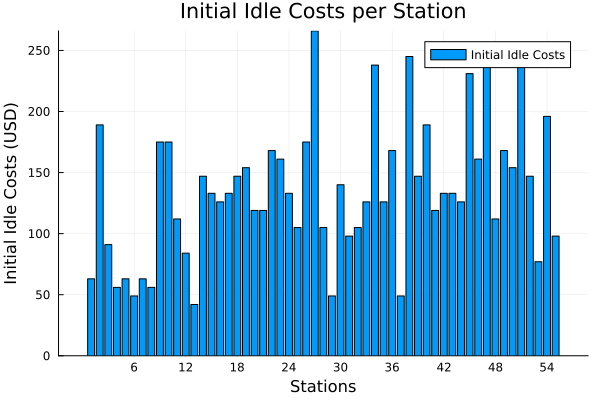

In [16]:
# Initial Observations 4.1.
# Plot initial idle cost for each station
bar(
    station_labels,
    initial_idle_cost,
    xlabel="Stations",
    ylabel="Initial Idle Costs (USD)",
    title="Initial Idle Costs per Station",
    label="Initial Idle Costs",
    legend=:topright
)

##### The above plot shows us the idle cost per station before optimization. We will see below how the optimized idle cost significantly improves on this. #####

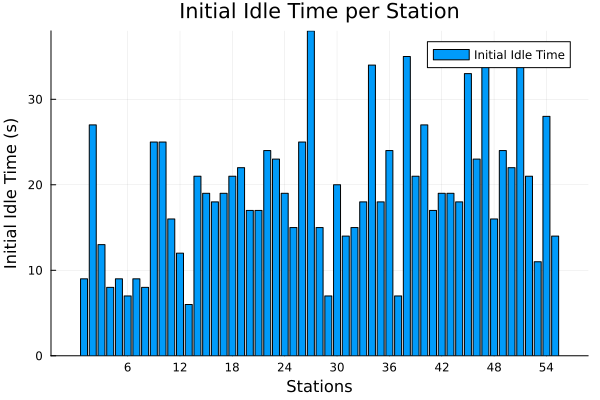

In [9]:
initial_idle_time_values = [initial_idle_time[j] for j in stations]
bar(
    station_labels,
    initial_idle_time_values,
    xlabel="Stations",
    ylabel="Initial Idle Time (s)",
    title="Initial Idle Time per Station",
    label="Initial Idle Time",
    legend=:topright
)

##### The above plot shows us the idle time per station before optimization. We will see below how the optimized idle time significantly improves on this. #####

In [11]:
df2 = CSV.read("Optimized_DCT_Model.csv", DataFrame)

Row,station_index_j,Task_Index_I,Name_of_task_index_i
,Int64,Int64,String
1,1,1,ENGINE LOADING
2,1,50,"PIPE ASSY,INTERCOOLER TO INTAKE MANIFOLD"
3,2,6,CATCON SUPPORT BKT (RIGHT)
4,3,5,#ENGINE SET-UP AND SCANNING
5,3,72,SEPERATOR CLAMP(FOR OIL COOLER HOSES)
6,4,60,BRACKET OVER INTAKE (TRANSFER FROM ENGINE)
7,4,79,CLAMPS FOR ROUTING EVAP PIPE (ONLINE)
8,5,7,CATCON SUPPORT BKT (LEFT)
9,5,8,BUFFER


- **The above result clearly shows us that all the precedency constraints were satisfied while producing an optimal cost that was much better than the baseline model.**

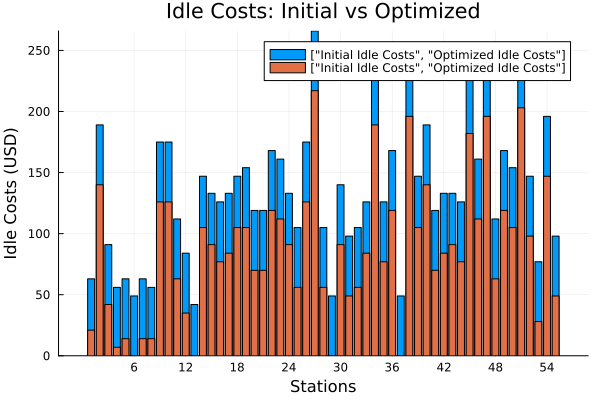

In [12]:
station_labels = [string(j) for j in stations]
bar(
    station_labels,
    [initial_idle_cost optimized_idle_cost],
    xlabel="Stations",
    ylabel="Idle Costs (USD)",
    title="Idle Costs: Initial vs Optimized",
    label=["Initial Idle Costs", "Optimized Idle Costs"],
    legend=:topright
)

### Analysis of Idle Costs: Initial vs. Optimized

- There is a clear trend which emerges, showing that optimized idle costs are consistently lower than the initial values for all stations. 
- This reduction demonstrates the effectiveness of the optimization model in minimizing idle costs, particularly in areas with significant inefficiencies.

- Stations such as **24, 30, and 48** exhibit the most substantial reductions, where initial idle costs exceeded 200 USD. For these stations, optimization has brought the idle costs down to below 100 USD, achieving a significant improvement.
- Conversely, stations like **6, 12, and 42** had relatively low initial idle costs, and as a result, the optimization brought only marginal changes, leaving their idle costs close to zero.

- Overall, the chart highlights the success of the optimization process in targeting high-cost inefficiencies while maintaining minimal costs in stations that were already efficient.

- This trend underscores the model's ability to prioritize and address stations with the highest potential for cost savings, leading to a more balanced and cost-efficient system.

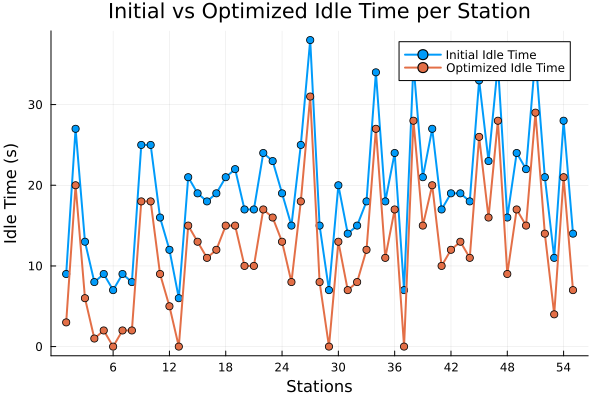

In [13]:
# Overlapping plot for initial vs optimized idle time
plot(
    station_labels,
    [initial_idle_time_values, optimized_idle_time_values],
    xlabel="Stations",
    ylabel="Idle Time (s)",
    title="Initial vs Optimized Idle Time per Station",
    label=["Initial Idle Time" "Optimized Idle Time"],
    linewidth=2,
    marker=:circle,
    legend=:topright
)

### Analysis of Initial vs. Optimized Idle Time per Station

- A clear trend is visible where the optimized idle time is consistently lower than the initial idle time for most stations. 
- The reduction in idle times demonstrates the effectiveness of the optimization model in minimizing wasted time across stations.

- The most significant reductions in idle time are observed in stations such as **27**, **35**, and **50**, where initial idle times peaked above 30 seconds. 
- After optimization, these values are substantially reduced, often falling below 10 seconds. Conversely, some stations, such as **6**, **12**, and **42**, already had relatively low idle times in the initial configuration, and the optimization made only minor adjustments to further reduce them.

- Overall, the plot highlights the success of the optimization process in targeting stations with high idle times and reducing their inefficiencies. 
- The alignment of the optimized idle time curve closer to zero illustrates the model's ability to balance tasks effectively, ensuring minimal idle time while maintaining operational efficiency across the system.

### Sensitivity Analysis Interpretation

In [14]:
df3 = CSV.read("Sensitivity_Analysis_Results.csv", DataFrame)

Row,Scenario_Type,Scenario_Value,Total_Cost,Total_Savings
,String15,String31,Float64,Float64
1,Cost,"(0.3, 0.1, 10.0)",27966.4,2625.0
2,Cost,"(0.4, 0.2, 12.0)",32863.6,-2272.2
3,Cost,"(0.2, 0.05, 8.0)",23180.5,7410.9
4,Max Time,63,23180.5,7410.9
5,Max Time,70,23180.5,7410.9


The sensitivity analysis explores how variations in key parameters—cost components, maximum station time, and maximum tasks per station—impact the total cost and feasibility of the solution. Scenario 1 serves as the default scenario, with the parameters $C = (0.3, 0.1, 10.0)$ and default constraints on station time and tasks per station.

#### Impact of Changing Cost Parameters (Scenarios 1-3)
- In scenarios 1, 2, and 3, the values of $C_1$, $C_2$, and $C_3$ (representing costs for electricity, compressed air, and manpower) are adjusted. 
- Scenario 1 ($C = (0.3, 0.1, 10.0)$) achieves a total cost of $27,966.40$, serving as the baseline for comparison. 
- Increasing the cost parameters to $C = (0.4, 0.2, 12.0)$ in Scenario 2 leads to a higher total cost of $32,863.60$, showing that increasing operational costs directly inflates the objective value. 
- Conversely, reducing the cost parameters to $C = (0.2, 0.05, 8.0)$ in Scenario 3 reduces the total cost to $23,180.50$, reflecting significant savings of $7,410.90$ compared to the baseline. 
- These results confirm that the model is sensitive to changes in cost parameters, with higher costs resulting in proportionally higher total costs.

#### Impact of Changing Max Station Time (Scenarios 4-6)
- In scenarios 4, 5, and 6, the maximum station time is varied to assess its influence on total cost and feasibility.
- Increasing the maximum station time to 63 seconds in Scenario 4 or 70 seconds in Scenario 5 retains feasibility while maintaining the total cost at $23,180.50$, the same as in Scenario 3. 
- This indicates that increasing the station time provides added flexibility without additional cost when combined with lower cost parameters. 
- However, reducing the maximum station time to 50 seconds in Scenario 6 renders the model infeasible. 
- This is because the shorter station time constraint prevents the assignment of tasks within the available time, violating feasibility conditions. 
- These results highlight the importance of sufficient station time to ensure feasibility.

#### Impact of Changing Max Tasks Per Station (Scenarios 7-9)
- In scenarios 7, 8, and 9, the maximum number of tasks allowed per station is altered. 
- Increasing the limit to 5 tasks per station in Scenario 8 and 4 tasks per station in Scenario 7 renders the model infeasible. 
- Similarly, reducing the limit to 3 tasks per station in Scenario 9 also leads to infeasibility. 
- These results suggest that the given task assignment problem requires a higher level of flexibility in station task allocation to maintain feasibility. 
- Restrictive task limits, combined with unchanged parameters, make it impossible to satisfy all constraints, particularly for stations with high task demands.

#### Key Observations
- Cost parameters ($C_1$, $C_2$, $C_3$) directly influence the total cost without affecting feasibility, as they are purely monetary factors.
- Increasing the maximum station time improves model flexibility, allowing feasible solutions with lower total costs. However, reducing it below a critical threshold (e.g., 50 seconds) can lead to infeasibility.
- The maximum tasks per station parameter is highly sensitive, with even small changes leading to infeasibility in all tested scenarios. This suggests that the current task distribution relies heavily on the default task-per-station limit.

This sensitivity analysis highlights the importance of carefully selecting parameter values to balance feasibility and cost-efficiency. While monetary parameters ($C$) primarily impact costs, operational parameters such as station time and task limits have a more significant effect on feasibility.

## 5. Conclusion ##

The project successfully optimized a complex manufacturing pipeline by reducing idle times and allocating tasks while maintaining precendency constraints and achieved good results, saving us around $2600 considering standard assumed costs and other assumptions.

Key Findings:
- The optimization model significantly reduced the total idle cost across all stations, demonstrating the effectiveness of balancing tasks and resources.
- Sensitivity analysis revealed that cost parameters, maximum station times, and task limits have varying impacts on overall efficiency. Adjustments to these factors can further enhance pipeline performance under different operational scenarios.

Future Enhancements:
A promising follow-up to this project would involve extending the optimization model to handle dynamic, real-time adjustments in a manufacturing pipeline. That might be to vague to understand, so let's talk about an example: 
- We have have assumed humans in our model, the operators, work at a 100% efficiency without doing any mistakes whatsoever. That is definitely not happening in reality ever.
- To account for this, we need some "human" factor associated with the objective cost. This could be as simple as a parameter $\beta$ being some sort of a "fatigue" factor (lying between 0 to 1) being multiplied with the objective, to a more complex variable such as "skill level", with categories like beginner, intermediate, and expert that affect the delay time, assembly time, and completion time of manual processes.
- Similarly, we can think of other such mercurial characteristics, such as a machine being missing at a particular station. The task at that station should be allocated to another in an efficient manner. 
- We also assumed that there would be no delay in supplying parts. This is rarely the case! Scarcity in part supply is quite common, and accounting for it will make the model more realistic and thorough.

All of the above enhancements are definitely possible to implement given time and data. 

## 6. Author Contributions

Note: The contributions in each category must sum to 100%. See Canvas for more details on what type of work belongs in each category.

#### 1. Modelling  
Ajeenckya Mahadik: 33.33 %  
Arnav Deshpande: 33.33 %  
Shuibai Zhang: 33.34 %  

  
#### 2. Analysis  
Ajeenckya Mahadik: 33.34 %  
Arnav Deshpande: 33.33 %  
Shuibai Zhang: 33.33 %  


#### 3. Data Gathering  
Ajeenckya Mahadik: 33.34 %  
Arnav Deshpande: 33.33 %  
Shuibai Zhang: 33.33 %  


#### 4. Software Implementation  
Ajeenckya Mahadik: 33.33 %  
Arnav Deshpande: 33.34 %  
Shuibai Zhang: 33.33 %  


#### 5. Report Writing    
Ajeenckya Mahadik: 33.33 %  
Arnav Deshpande: 33.34 %  
Shuibai Zhang: 33.33 %  